# Exploratory Data Analysis - KPO
Poniższa analiza powstała na skutek polaryzującej opinii publicznej publikacji beneficjentów Krajowego Planu Odbudowy z zakresu HoReCa (branża hotelowa i gastronomiczna).

Krajowy Plan Odbudowy (KPO) to polski program reform i inwestycji będący częścią unijnego Instrumentu na rzecz Odbudowy i Zwiększenia Odporności, który stanowi główny element Next GenerationEU. Plan ma pomóc Polsce w łagodzeniu społecznych i gospodarczych skutków pandemii COVID-19. Część środków przyznawana jest z funduszu unijnego do pełnego wykorzystania, zaś część w formie pożyczek.

Ponieważ skrajne emocje wywoływały absurdy dotyczące wysokości dofinansowań i ich przeznaczenia, postanowiłem "rozbroić" dostępne dane i zwizualizować to, co nie jest widoczne na pierwszy rzut oka.

Źródłem danych do analizy była mapa inwestycji zamieszczona na oficjalnej stronie: https://www.kpo.gov.pl/strony/horeca/. Została ona pobrana w formie pliku .kml i później przekonwertowana do bazy danych.

Pytania które zostały zaadresowane:
* Ile inwestycji przypadało na województwo i miasto?
* Ile pieniędzy na inwestycje przypadało na województwo i miasto?
* Jaki był rozkład (udział) liczby inwestycji i wartości wsparcia dla województw i miast?
* Jak wyglądał rozkład wartości wsparcia?
* Jaki był udział inwestycji powyżej danej kwoty wsparcia?
* Jakie były najczęściej występujące słowa we wnioskach o dofinansowanie?
* Jaka pula pieniędzy przypadała na jednego mieszkańca danego miasta?
* Ile pieniędzy zostało przeznaczonych na "nietypowe" inwestycje?

## Imports

Import bibliotek niezbędnych do konwersji, modyfikacji i wizualizacji danych.

In [5]:
import re
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Data load

Dane w formie pobranego pliku .kml zostały zaczytane i przygotowane do konwersji.

In [8]:
# Load and parse the KML
file_path = "HoReCa.kml"
tree = ET.parse(file_path)
root = tree.getroot()

# Namespace for KML
ns = {'kml': 'http://www.opengis.net/kml/2.2'}

## Data unpack

Plik .kml został przekonwertowany do łatwej w obsłudze bazy danych.

In [11]:
investments = []

for placemark in root.findall(".//kml:Placemark", ns):
    data_entry = {
        "Nazwa przedsięwzięcia": None,
        "Nazwa": None,
        "Miejsce Realizacji Województwo": None,
        "Grantobiorca Miejscowość": None,
        "Grantobiorca Ulica": None,
        "Grantobiorca Nr budynku": None,
        "Grantobiorca Kod pocztowy": None,
        "Wartość wsparcia": None
    }
    
    # Get "Nazwa przedsięwzięcia" from <name> tag
    name_tag = placemark.find("kml:name", ns)
    if name_tag is not None:
        data_entry["Nazwa przedsięwzięcia"] = name_tag.text.strip()
    
    # Get description text
    desc_tag = placemark.find("kml:description", ns)
    if desc_tag is not None and desc_tag.text:
        desc_text = desc_tag.text
        
        # Replace <br> with newlines
        desc_text = re.sub(r"<br\s*/?>", "\n", desc_text)
        # Remove other HTML tags
        desc_text = re.sub(r"<.*?>", "", desc_text)
        
        for line in desc_text.splitlines():
            line = line.strip()
            if ": " in line:
                key, value = line.split(": ", 1)
                key = key.strip()
                value = value.strip()
                if key in data_entry:
                    data_entry[key] = value
    
    investments.append(data_entry)
    df = pd.DataFrame(investments)

## Data understanding

Wyświetlenie początkowych i losowych wierszy pozwala na lepsze zrozumienie struktury i formy danych. Uwagę przykuwa choćby niejednolity format nazw województw.

In [14]:
df.head()

,Nazwa przedsięwzięcia,Nazwa,Miejsce Realizacji Województwo,Grantobiorca Miejscowość,Grantobiorca Ulica,Grantobiorca Nr budynku,Grantobiorca Kod pocztowy,Wartość wsparcia
0,"Wdrożenie w działalności Wnioskodawcy nowej, n...",CLEOPATRA PREMIUM SPÓŁKA Z OGRANICZONĄ ODPOWIE...,Łódzkie,Lublin,Trześniowska,63,20-227,469807.87
1,Wzmocnienie odporności firmy OZDOBA I SYN S.C....,OZDOBA I SYN S.C.,ŁÓDZKIE,Łódź,None,8,94-302,292095
2,Wzmocnienie odporności Restauracji Pod Czaplą ...,Restauracja Pod Czaplą Dobrowolscy spółka cywilna,ŚLĄSKIE,Bytom,Stanisława Moniuszki,8,41-902,305690.6
3,Inwestycja spółki WIOLETTA I MICHAŁ LISZOWSCY ...,WIOLETTA I MICHAŁ LISZOWSCY SPÓŁKA CYWILNA,ŚLĄSKIE,Żory,Józefa Mikołajca,17,44-240,113032.23
4,Projekt ZIELONA OLIWKA: Rewolucja w gastronomi...,"PRZEDSIĘBIORSTWO USŁUGOWO-HANDLOWE ""IWO"" IWONA...",ŚLĄSKIE,Zabrze,Jagiellońska,38,41-800,416997.9


In [15]:
df.sample(10)

,Nazwa przedsięwzięcia,Nazwa,Miejsce Realizacji Województwo,Grantobiorca Miejscowość,Grantobiorca Ulica,Grantobiorca Nr budynku,Grantobiorca Kod pocztowy,Wartość wsparcia
640,Rozszerzenie działalności o usługę zapewnienia...,Anna Zimna Biuro Podróży Traveleiro,DOLNOŚLĄSKIE,Wrocław,Eugeniusza Horbaczewskiego,4-6,54-130,217921.5
1235,"„„BAR Z PRZEKĄSKAMI – SZYBKA, ZDROWA, EKOLOGIC...",TAWERNA RAFA STASZKÓW SPÓŁKA KOMANDYTOWA,POMORSKIE,Chojnice,Droga do Igieł,1,89-600,517214.53
586,Dywersyfikacja działalności firmy Grzemi Sp. z...,Grzemi Spółka z ograniczoną odpowiedzialnością,WIELKOPOLSKIE,Poznań,Lutycka,34,60-415,477000
33,Nowy wymiar Hotelu Krokus w Wiśle - region śląski,Przedsiębiorstwo KOMPOL Spółka z ograniczoną o...,ŚLĄSKIE,Bielsko-Biała,Kazimierza Pułaskiego,4A,43-300,504000
2411,Wzmocnienie odporności przedsiębiorstwa STIXX ...,STIXX SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIALNOŚCIĄ,MAZOWIECKIE,Warszawa,pl. Plac Europejski,4a,00-844,413404.09
1258,Zwiększenie odporności przedsiębiorstwa ESENTR...,ESENTRA SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIALNOŚCIĄ,POMORSKIE,Sopot,Aleja Niepodległości,799 A,81-810,502899.95
1784,Cynamonka: Rewolucja w Wypale Kawy i Wypiekach...,Joanna Pichur i Maciej Zamirski Maestria Spółk...,PODKARPACKIE,Przemyśl,3 Maja,5,37-700,355590
1947,Rozszerzenie oferty firmy PROJEKT STRZELNICA M...,"PROJEKT STRZELNICA M. BRĄGIEL, R. ZIELIŃSKI SP...",MAŁOPOLSKIE,Kraków,Królowej Jadwigi,220,30-218,412462.68
1468,Rozszerzenie oferty o stanowiska gastronomiczn...,"Restauracja ""Trzy Korony"" Andrzej Labudda",POMORSKIE,Wejherowo,Jana III Sobieskiego,296,84-200,88954.41
1503,Zwiększenie odporności i dywersyfikacja działa...,SŁAWOMIR TWORKOWSKI,POMORSKIE,Gdańsk,Pólnicy,18,80-177,297657.9


Ramka danych zawiera 2889 wierszy (zatem 2889 inwestycji) oraz 8 kolumn.

In [17]:
df.shape

(2889, 8)

Poniżej wyświetlone zostały nazwy kolumn, będą one w późniejszym czasie uproszczone.

In [19]:
df.columns

Index(['Nazwa przedsięwzięcia', 'Nazwa', 'Miejsce Realizacji Województwo',
       'Grantobiorca Miejscowość', 'Grantobiorca Ulica',
       'Grantobiorca Nr budynku', 'Grantobiorca Kod pocztowy',
       'Wartość wsparcia'],
      dtype='object')

Chociaż poniższa komenda `describe` nie jest na tym etapie przystowana do właściwego typu kolumn, można wywnioskować chociażby że kolumna `Grantobiorca Ulica` posiada znaczne braki, najwyższa wartość wsparcia to 540 tyś. PLN, a najczęściej występujące województwo i miasto to Mazowieckie i Warszawa.

In [21]:
df.describe()

,Nazwa przedsięwzięcia,Nazwa,Miejsce Realizacji Województwo,Grantobiorca Miejscowość,Grantobiorca Ulica,Grantobiorca Nr budynku,Grantobiorca Kod pocztowy,Wartość wsparcia
count,2889,2889,2889,2889,2504,2889,2889,2889
unique,2882,2885,30,1090,1418,572,1841,2599
top,Rozszerzenie działalności firmy poprzez wdroże...,APM PARTNERS SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIAL...,MAZOWIECKIE,Warszawa,Tadeusza Kościuszki,1,43-300,540000
freq,2,2,409,243,36,160,25,156


Metoda `info` pozwala na sprawdzenie typu danych w każdej kolumnie i potwierdzenie niekompletności danych. Ponieważ w tym przypadku każdy typ to `object`, niektóre oczywiste kolumny z wartościami liczbowymi jak `Wartość wsparcia` zostaną przekonwertowane.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Nazwa przedsięwzięcia           2889 non-null   object
 1   Nazwa                           2889 non-null   object
 2   Miejsce Realizacji Województwo  2889 non-null   object
 3   Grantobiorca Miejscowość        2889 non-null   object
 4   Grantobiorca Ulica              2504 non-null   object
 5   Grantobiorca Nr budynku         2889 non-null   object
 6   Grantobiorca Kod pocztowy       2889 non-null   object
 7   Wartość wsparcia                2889 non-null   object
dtypes: object(8)
memory usage: 180.7+ KB


## Data preparation

### Datatypes check & fix

Aby zapewnić użyteczność kolumny `Wartość wsparcia`, zostanie ona przekonwertowana na typ liczbowy.

In [27]:
df["Wartość wsparcia"] = pd.to_numeric(df["Wartość wsparcia"], errors="coerce")

Została ona typem `float`, który to typ zmiennoprzecinkowy posłuży do dalszej analizy.

In [29]:
df.dtypes

Nazwa przedsięwzięcia              object
Nazwa                              object
Miejsce Realizacji Województwo     object
Grantobiorca Miejscowość           object
Grantobiorca Ulica                 object
Grantobiorca Nr budynku            object
Grantobiorca Kod pocztowy          object
Wartość wsparcia                  float64
dtype: object

### Column names

Nazwy kolumn zostały zmienione w celu łatwiejszego odnoszenia się do nich w zapytaniach.

In [32]:
df.rename(columns={'Nazwa przedsięwzięcia':'Investment', 
                   'Nazwa':'Name', 
                   'Miejsce Realizacji Województwo':'Voivodeship', 
                   'Grantobiorca Miejscowość':'City', 
                   'Grantobiorca Ulica':'Street',
                   'Grantobiorca Nr budynku':'Building',
                   'Grantobiorca Kod pocztowy':'Postal',
                    'Wartość wsparcia':'Money'},
                    inplace=True)

Zmienone nazwy kolumn są już widoczne w początkowych kolumnach zaprezentowanych poniżej.

In [34]:
df.head()

,Investment,Name,Voivodeship,City,Street,Building,Postal,Money
0,"Wdrożenie w działalności Wnioskodawcy nowej, n...",CLEOPATRA PREMIUM SPÓŁKA Z OGRANICZONĄ ODPOWIE...,Łódzkie,Lublin,Trześniowska,63,20-227,469807.87
1,Wzmocnienie odporności firmy OZDOBA I SYN S.C....,OZDOBA I SYN S.C.,ŁÓDZKIE,Łódź,None,8,94-302,292095.00
2,Wzmocnienie odporności Restauracji Pod Czaplą ...,Restauracja Pod Czaplą Dobrowolscy spółka cywilna,ŚLĄSKIE,Bytom,Stanisława Moniuszki,8,41-902,305690.60
3,Inwestycja spółki WIOLETTA I MICHAŁ LISZOWSCY ...,WIOLETTA I MICHAŁ LISZOWSCY SPÓŁKA CYWILNA,ŚLĄSKIE,Żory,Józefa Mikołajca,17,44-240,113032.23
4,Projekt ZIELONA OLIWKA: Rewolucja w gastronomi...,"PRZEDSIĘBIORSTWO USŁUGOWO-HANDLOWE ""IWO"" IWONA...",ŚLĄSKIE,Zabrze,Jagiellońska,38,41-800,416997.90


### Handling duplicates

Duplikaty zostały zlokalizowane poniżej. Ponieważ mało prawdopodobne jest aby dane przedsięwzięcie uzyskało dwa takie same dofinansowania, zostaną one usunięte. Najprawdopodobniej został popełniony błąd przy tworzeniu mapy przez autorów zestawienia.

In [37]:
df.loc[df.duplicated()]

,Investment,Name,Voivodeship,City,Street,Building,Postal,Money
224,Rozszerzenie działalności firmy poprzez wdroże...,APM PARTNERS SPÓŁKA Z OGRANICZONĄ ODPOWIEDZIAL...,ŁÓDZKIE,Łódź,Targowa,35,90-043,135702.85
2000,Zwiększenie odporności przedsiębiorstwa na syt...,Aneta Bednarska,ŚWIĘTOKRZYSKIE,Solec-Zdrój,1 Maja,1,28-131,229529.19
2001,Zwiększenie odporności i rozszerzenie działaln...,"""VON HAGEN POLSKA"" SPÓŁKA Z OGRANICZONĄ ODPOWI...",ŚWIĘTOKRZYSKIE,Kielce,Klonowa,55,25-553,419400.45


Ramka danych została uszczuplona o znalezione duplikaty.

In [39]:
df = df.loc[~df.duplicated()].reset_index(drop=True).copy()

In [40]:
df.loc[df.duplicated()]

,Investment,Name,Voivodeship,City,Street,Building,Postal,Money


3 znalezione duplikaty zostały usunięte.

### Handling missing values

Wyświetlone zostały brakujące wiersze w danych kategoriach (kolumnach).

In [44]:
df.isna().sum().sort_values(ascending=False)

Street         385
Investment       0
Name             0
Voivodeship      0
City             0
Building         0
Postal           0
Money            0
dtype: int64

Mamy 385 pustych wartości dla nazwy ulicy. Prawdopodobnie część mniejszych miejscowości nie posiada nazw ulic. Spójrzmy jescze na heatmapę, żeby lepiej "poczuć" jak dużo danych brakuje.

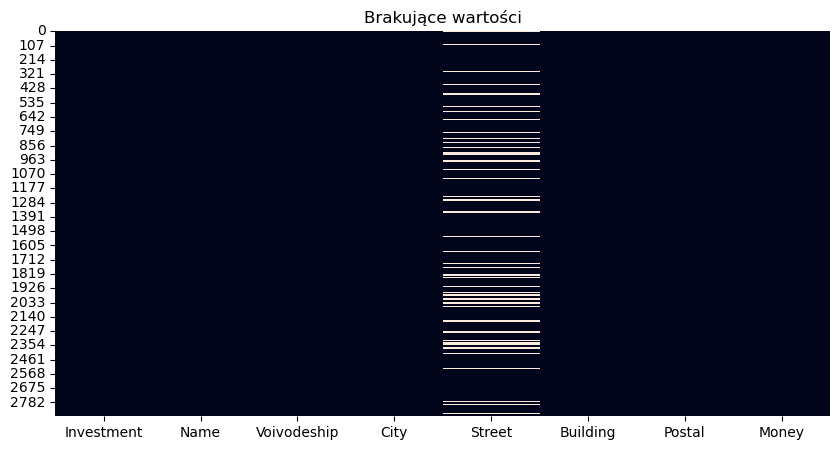

In [46]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cbar=False)
plt.title("Brakujące wartości")
plt.show()

Brakująca nazwa ulicy pojawia się dość często, ale nie powinno to zaburzyć wyników, ponieważ akurat nazwa ulicy nie jest specjalnie ważna w tej analizie.

### Check of real data
Spójrzmy na częstotliwość występowania poszczególnych wartości.

Niektóre województwa pojawiają się podwójnie (wielkimi i małymi literami).

In [50]:
df['Voivodeship'].value_counts()

Voivodeship
MAZOWIECKIE            409
POMORSKIE              310
ŚLĄSKIE                286
MAŁOPOLSKIE            278
WIELKOPOLSKIE          233
DOLNOŚLĄSKIE           231
ZACHODNIOPOMORSKIE     228
KUJAWSKO-POMORSKIE     123
ŁÓDZKIE                121
PODKARPACKIE           107
WARMIŃSKO-MAZURSKIE    107
LUBELSKIE               92
LUBUSKIE                68
OPOLSKIE                67
ŚWIĘTOKRZYSKIE          64
PODLASKIE               59
Śląskie                 36
Zachodniopomorskie      13
Łódzkie                 12
Pomorskie                9
Dolnośląskie             8
Opolskie                 8
Małopolskie              5
Kujawsko-pomorskie       3
Wielkopolskie            3
Podkarpackie             2
Świętokrzyskie           1
Śląśkie                  1
Warmińsko-Mazurskie      1
Podlaskie                1
Name: count, dtype: int64

Nazwy województw zostaną ujednolicone.

In [52]:
df['Voivodeship'] = df['Voivodeship'].str.capitalize()

Teraz zestawienie wygląda poprawnie jeżeli chodzi o wielkość liter.

In [54]:
df['Voivodeship'].value_counts()

Voivodeship
Mazowieckie            409
Śląskie                322
Pomorskie              319
Małopolskie            283
Zachodniopomorskie     241
Dolnośląskie           239
Wielkopolskie          236
Łódzkie                133
Kujawsko-pomorskie     126
Podkarpackie           109
Warmińsko-mazurskie    108
Lubelskie               92
Opolskie                75
Lubuskie                68
Świętokrzyskie          65
Podlaskie               60
Śląśkie                  1
Name: count, dtype: int64

Natomiast, uwagę przykuwa województwo "Śląśkie", co prawdopodobnie było błędem autorów przy wprowadzaniu do bazy.

In [56]:
df.loc[df['Voivodeship']=='Śląśkie']

,Investment,Name,Voivodeship,City,Street,Building,Postal,Money
316,Rozszerzenie działalności firmy Biuro Handlowo...,"Biuro Handlowo-Usługowe ""Strażnica"" Wiesław Biel",Śląśkie,Żywiec,Kościuszki,29,34-300,540000.0


Nazwa ta została zmieniona ze `Śląśkie` na `Śląskie`.

In [58]:
df['Voivodeship'] = df['Voivodeship'].replace('Śląśkie', 'Śląskie')
# df.loc[df['Voivodeship'] == 'Śląśkie', 'Voivodeship'] = 'Śląskie'

Dla sprawdzenia wyszukano ponownie województwo `Śląśkie`.

In [60]:
df.loc[df['Voivodeship']=='Śląśkie']

,Investment,Name,Voivodeship,City,Street,Building,Postal,Money


Nie znaleziono takiego województwa, więc proces sprawdzania poprawności tej kolumny można uznać za zakończony. Dla sprawdzenia wyświetlmy też czy liczba województw się zgadza.

In [62]:
len(df['Voivodeship'].value_counts())

16

Wartość jest poprawna, bo faktycznie województw jest 16. Dodatkowo w podobny sposób przeanalizujmy miasta.

In [64]:
df['City'].value_counts().head(30)

City
Warszawa         243
Kraków           133
Wrocław           90
Gdańsk            89
Poznań            79
Szczecin          76
Łódź              60
Gdynia            42
Lublin            39
Katowice          36
Bydgoszcz         36
Bielsko-Biała     27
Rzeszów           24
Białystok         22
Opole             22
Toruń             22
Olsztyn           22
Zielona Góra      21
Sopot             20
Kielce            18
Zakopane          17
Częstochowa       15
Wisła             14
Kołobrzeg         14
Gliwice           13
Radom             12
Koszalin          10
Kalisz            10
Nowy Sącz         10
Ruda Śląska       10
Name: count, dtype: int64

## Data visualization

Po przygotowaniu danych można przejść do ich wizualizacji. Uprzednio jednak, zadajmy pytania do tego zbioru, aby móc na nie odpowiedzieć:
* Ile inwestycji przypadało na województwo i miasto?
* Ile pieniędzy na inwestycje przypadało na województwo i miasto?
* Jaki był rozkład (udział) liczby inwestycji i wartości wsparcia dla województw i miast?
* Jak wyglądał rozkład wartości wsparcia?
* Jaki był udział inwestycji powyżej danej kwoty wsparcia?
* Jakie były najczęściej występujące słowa we wnioskach o dofinansowanie?
* Jaka pula pieniędzy przypadała na jednego mieszkańca danego miasta?
* Ile pieniędzy zostało przeznaczonych na "nietypowe" inwestycje?

### Count per voivodeship - top 10

Najwięcej inwestycji (powyżej 400) przypadło na województwo mazowieckie, na dalszych miejscach są województwa śląskie i pomorskie (powyżej 300). Pozostałe województwa mają mniej niż 300 inwestycji.

Dziwić może tak dużo inwestycji w województwie śląskim, pomimo jego dość niskiej powierzchni.

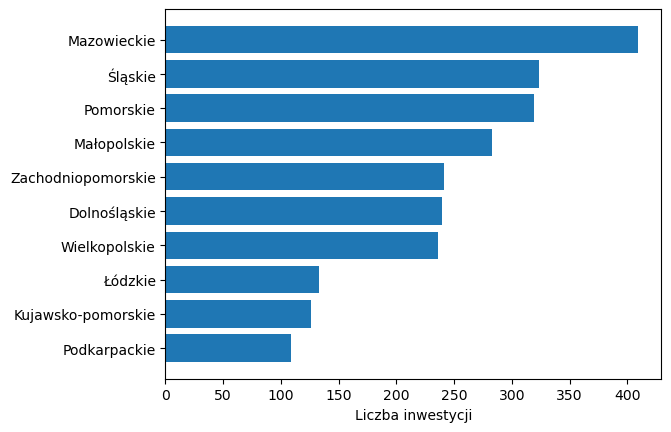

In [68]:
count_voivodeship = df['Voivodeship'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

ax.barh(count_voivodeship[6:].index, count_voivodeship[6:].values)
ax.set_xlabel('Liczba inwestycji')

plt.show()

### Money per voivodeship - top 10

Ranking wielkości dofinansowania wygląda podobnie jak dla liczby inwestycji. Największa pula przypadła na województwo mazowieckie (powyżej 170 mln PLN), pozostałymi województwami powyżej 100 mln PLN dofinansowania są pomorskie, śląskie i małopolskie.

In [71]:
money_voivodeship = df.groupby('Voivodeship')['Money'].agg('sum').sort_values(ascending=False)

In [72]:
money_voivodeship

Voivodeship
Mazowieckie            1.775111e+08
Pomorskie              1.332944e+08
Śląskie                1.330422e+08
Małopolskie            1.097289e+08
Zachodniopomorskie     1.016866e+08
Dolnośląskie           9.857265e+07
Wielkopolskie          9.731478e+07
Łódzkie                5.418184e+07
Kujawsko-pomorskie     5.217719e+07
Warmińsko-mazurskie    4.667646e+07
Podkarpackie           4.094274e+07
Lubelskie              3.625823e+07
Opolskie               3.318503e+07
Lubuskie               2.848973e+07
Podlaskie              2.509588e+07
Świętokrzyskie         2.311049e+07
Name: Money, dtype: float64

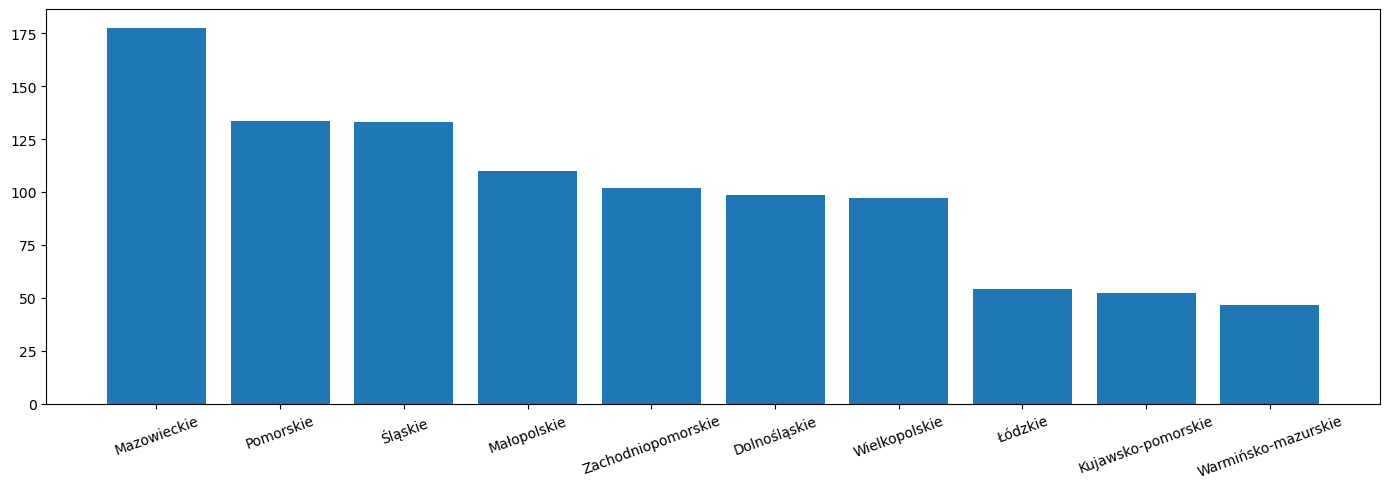

In [73]:
fig, ax = plt.subplots(figsize=(14,5))

ax.bar(money_voivodeship[:10].index, money_voivodeship[:10].values/1e6)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### Share count per voivodeship

Procentowy udział liczby inwestycji pozwala dodatkowo zauważyć, że prawie 25% zajmuje połowa pomniejszych województw.

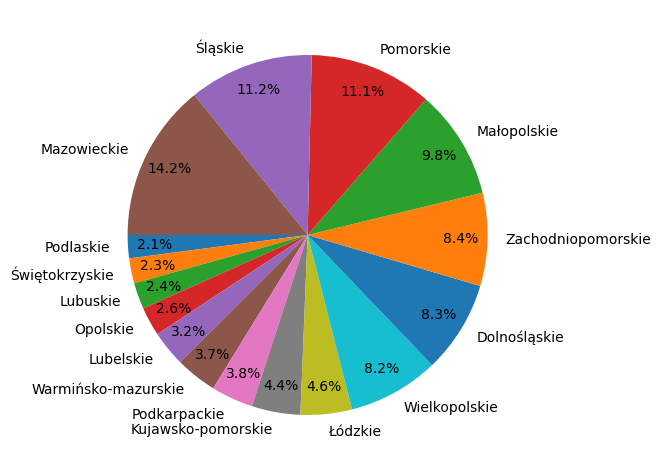

In [76]:
fig, ax = plt.subplots()

ax.pie(count_voivodeship,
      labels=count_voivodeship.index,
      startangle=180,
      autopct='%1.1f%%',
      pctdistance=0.85,
      labeldistance=1.1)

plt.tight_layout()
plt.show()

### Share money per voivodeship

Dla podziału pieniędzy statystyka wygląda bliźniaczo.

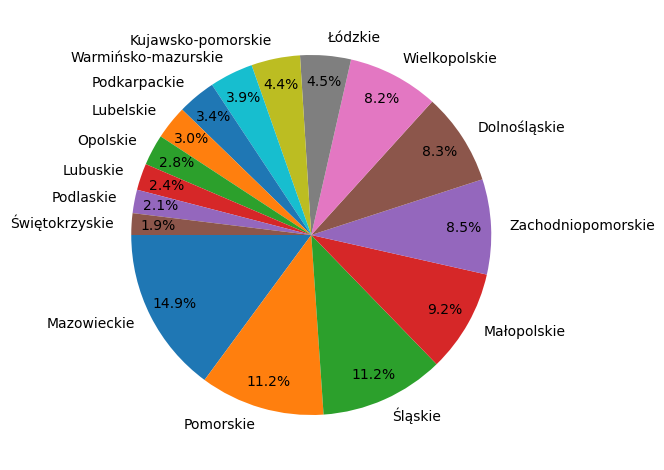

In [79]:
fig, ax = plt.subplots()

ax.pie(money_voivodeship,
      labels=money_voivodeship.index,
      startangle=180,
      autopct='%1.1f%%',
      pctdistance=0.85,
      labeldistance=1.1)

plt.tight_layout()
plt.show()

### Count per city - top 10

Dla rankingu miast z dofinansowaniem zdecydowanie dominuje Warszawa z prawie 250 inwestycjami. Na drugim miejscu jest Kraków z 133 inwestycjami, a pozostałe miasta mają poniżej 100 inwestycji

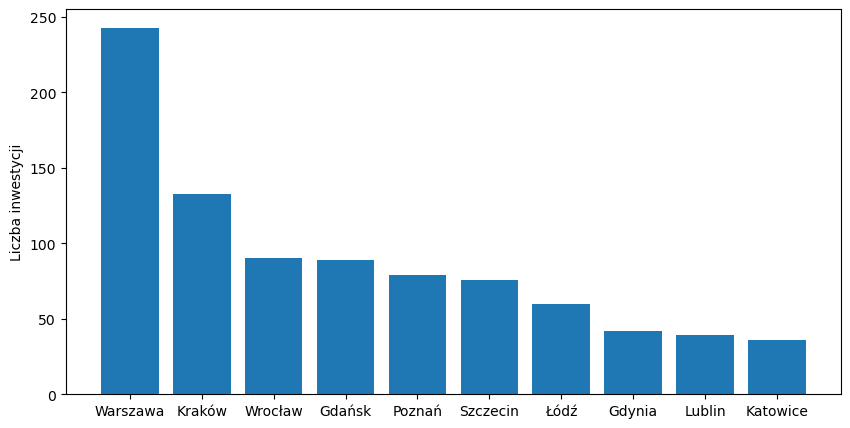

In [82]:
count_city = df['City'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(count_city[:10].index, count_city[:10].values)
ax.set_ylabel('Liczba inwestycji')

plt.show()

In [83]:
count_city.head(10)

City
Warszawa    243
Kraków      133
Wrocław      90
Gdańsk       89
Poznań       79
Szczecin     76
Łódź         60
Gdynia       42
Lublin       39
Katowice     36
Name: count, dtype: int64

### Money per city - top 10

Dla rozkładu pieniężnego ranking wygląda podobnie z sumą dofinansowania dla Warszawy powyżej 100 mln PLN.

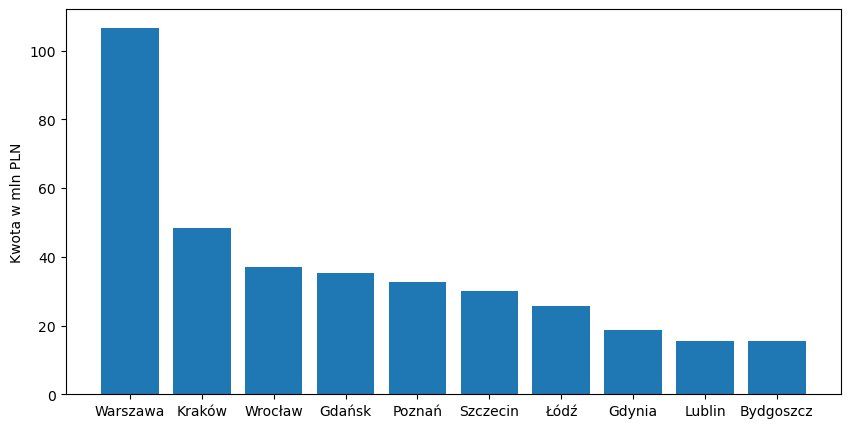

In [86]:
money_city = df.groupby('City')['Money'].agg('sum').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(money_city[:10].index, money_city[:10].values/1e6)
ax.set_ylabel('Kwota w mln PLN')

plt.show()

### Histogram

Histogram inwestycji pokazuje, że znaczna większość podań kierowana była na maksymalizację wysokości dofinansowania.

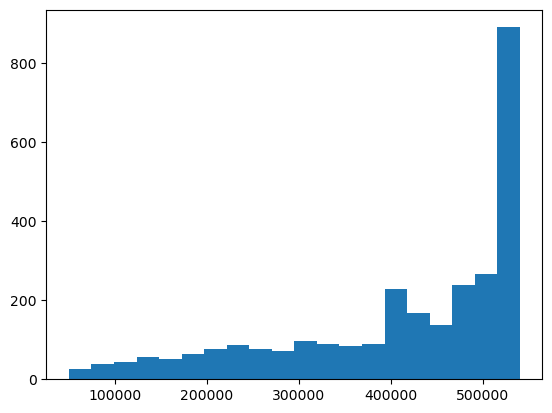

In [89]:
fig, ax = plt.subplots()

ax.hist(df['Money'],
       bins = 20)
#ax.axvline(df['Money'].mean(), color='k', linestyle='dashed', linewidth=1.5)


plt.show()

### Boxplot

Szerszy ogląd można uzyskać dzięki wykresowi pudełkowemu, który obrazuje jak rozkładają się wartości max/min, kwadryle i mediana dla wartości inwestycji.  
Aż 75% inwestycji ubiegało o więcej niż 326 tyś. PLN dofinansowania. Najwyższa i najniższa wartość dofinansowania wyniosły odpowiednio 540 tyś. PLN i 50 tyś. PLN, zaś mediana 456 tyś. PLN.

In [92]:
df.Money.describe()

count      2886.000000
mean     412774.852994
std      132307.441767
min       50000.690000
25%      326730.222500
50%      456867.945000
75%      531900.000000
max      540000.000000
Name: Money, dtype: float64

In [93]:
df.Money.median()

456867.945

<Axes: >

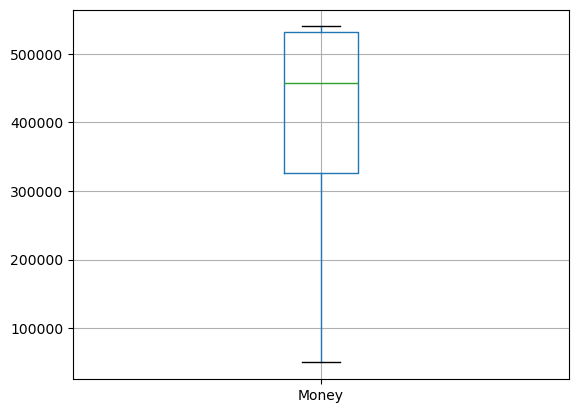

In [94]:
df.boxplot(column='Money')

Dodatkowo nanieść można poszczególne inwestycje, pokazując gęstość danych dla zakresów.

<Axes: ylabel='Money'>

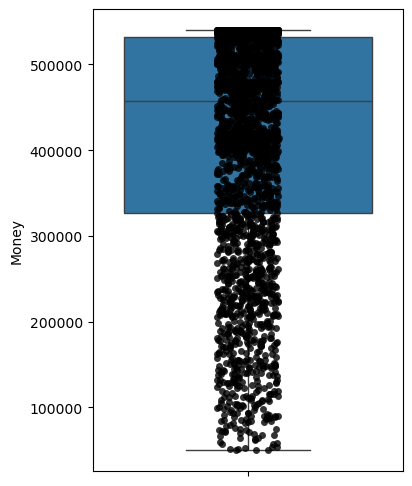

In [96]:
plt.figure(figsize=(4,6))


sns.boxplot(y = 'Money', data = df) 
sns.stripplot(y = 'Money', data = df,
              jitter=True, 
              marker='o',
              alpha=0.8, 
              color="black")

### Proportion 400k

Ponieważ rozkład wysokości inwestycji okazał się mocno przesunięty w stronę wyższych kwot, dodatkowo zwizualizowana została proporcja inwestycji powyżej i poniżej 400 tyś. PLN.

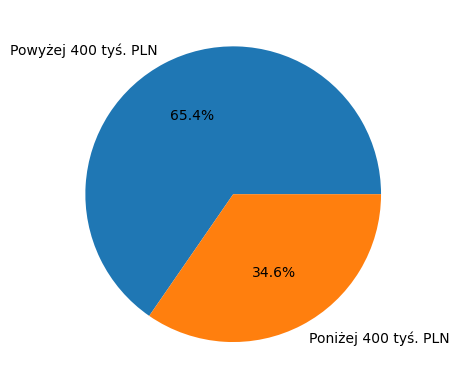

In [99]:
more400 = df['Money']>=400000
less400 = df['Money']<400000

fig, ax = plt.subplots()

ax.pie([more400.sum(), less400.sum()],
      labels=['Powyżej 400 tyś. PLN', 'Poniżej 400 tyś. PLN'],
      autopct='%1.1f%%')


plt.show()

### Most common words in funding application

Poniżej przeanalizowane zostały słowa użyte w tytułach wniosków. W prawie połowie pojawiło się słowo `dywersyfikacja`, podkreślając szerokie spojrzenie na biznes. Poza tym pojawiały się słowa podkreślające rozszerzenie, wdrożenie, zwiększenie pod kątem rozwoju przedsiębiorstwa, tworząc odporność na sytuacje kryzysowe.

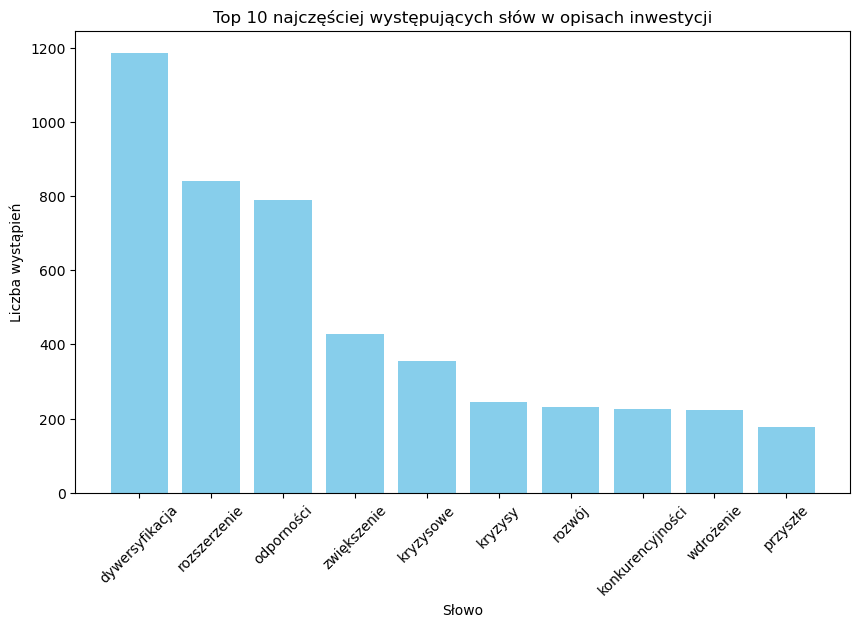

In [102]:
all_words = []

for text in df["Investment"].dropna().astype(str):
    words = re.findall(r"\w+", text.lower())
    all_words.extend(words)

word_counts = Counter(all_words)

stopwords = {"i", "na", "do", "oraz", "z", "w", "o", "dla", "od", "po", "u", "poprzez", "działalności", "usług", "firmy", "region", "usługi",
            "wprowadzenie", "województwie", "nowych", "oferty", "regionie", "nowej", "przedsiębiorstwa", "województwa", "sytuacje", 
             "województwo", "celu", "terenie", "prowadzonej", "dywersyfikację", "pomorskie"}  
filtered_counts = {word: count for word, count in word_counts.items() if word not in stopwords and len(word) > 3}

top10 = Counter(filtered_counts).most_common(10)

words, counts = zip(*top10)
plt.figure(figsize=(10,6))
plt.bar(words, counts, color="skyblue")
plt.title("Top 10 najczęściej występujących słów w opisach inwestycji")
plt.ylabel("Liczba wystąpień")
plt.xlabel("Słowo")
plt.xticks(rotation=45)
plt.show()


### Funding per category

Dla słów kluczowych z danych branż i obszarów zostały stworzone podsumowania wartości inwestycji.

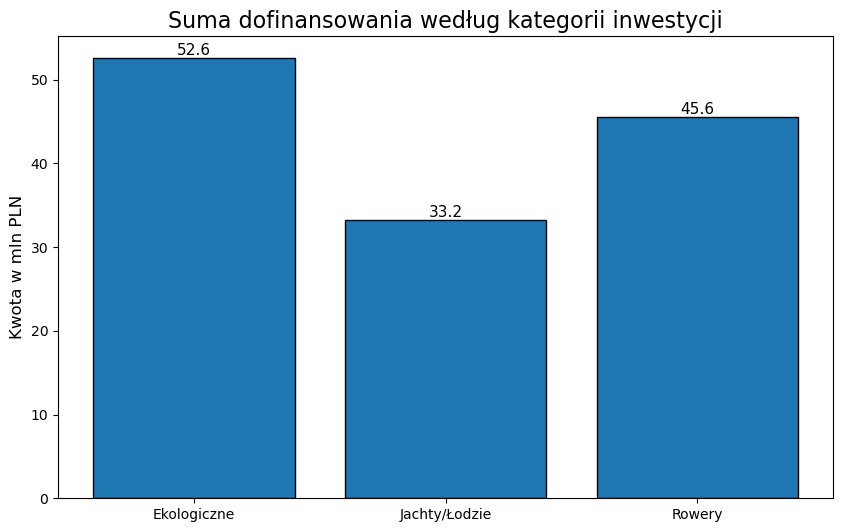

In [105]:
categories = {
    "Ekologiczne": ["ekologi", "zeroemisyjn", "odnawialn", "fotowolt", "panel", "solarn"],
    "Jachty/Łodzie": ["jacht", "łodzi"],
    "Rowery": ["rower"],
}

category_sums = {cat: 0 for cat in categories}

for _, row in df.iterrows():
    investment_text = str(row["Investment"])
    amount = row["Money"]  # kolumna z kwotą
    for cat, keywords in categories.items():
        if any(keyword in investment_text for keyword in keywords):
            category_sums[cat] += amount

category_sums_mln = {k: v/1e6 for k,v in category_sums.items()}

plt.figure(figsize=(10,6))
bars = plt.bar(category_sums_mln.keys(), category_sums_mln.values(), color='#1f77b4', edgecolor='black')
plt.title("Suma dofinansowania według kategorii inwestycji", fontsize=16)
plt.ylabel("Kwota w mln PLN", fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.1f}', ha='center', va='bottom', fontsize=11)

plt.show()


## Final charts
Kumulatywne wykresy użyte do publikacji w serwisie Linkedin:  
https://www.linkedin.com/posts/jakub-flak_kpo-activity-7362619471070474240-gXjN?utm_source=share&utm_medium=member_desktop&rcm=ACoAADUlqzMBoizovW-PvYejqHd84NyA77rYdf0

### Voivodeship

C:\Users\WIZBOX\AppData\Local\Temp\ipykernel_9324\820856728.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(money_voivodeship.index, rotation=30, ha='right')


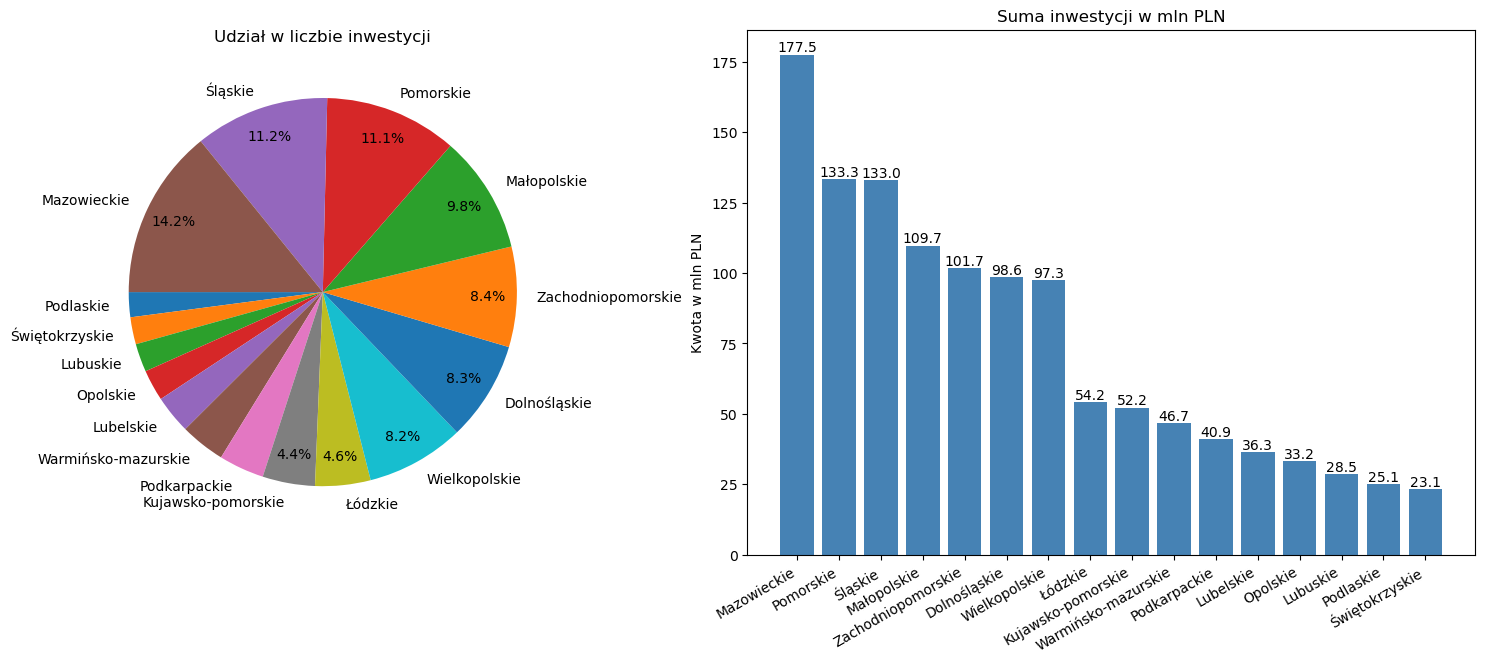

In [108]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(18, 7),
    gridspec_kw={'width_ratios': [1, 1.5]}  # prawy wykres szerszy
)

# --- wykres kołowy ---
ax1.pie(
    count_voivodeship,
    labels=count_voivodeship.index,
    autopct=lambda pct: f"{pct:.1f}%" if pct >= 4 else "",
    startangle=180,
    pctdistance=0.85,
    labeldistance=1.1
)
ax1.set_title("Udział w liczbie inwestycji")

# --- wykres słupkowy ---
bars = ax2.bar(money_voivodeship.index, money_voivodeship.values/1e6, color='steelblue')
ax2.set_title("Suma inwestycji w mln PLN")
ax2.set_ylabel("Kwota w mln PLN")
ax2.set_xticklabels(money_voivodeship.index, rotation=30, ha='right')
ax2.bar_label(bars, fmt='%.1f')

# --- dostosowanie layoutu ---
plt.subplots_adjust(top=0.9, bottom=0.15, wspace=0.3)  # więcej miejsca dla X i margines od góry

plt.savefig("voivodeship.png", dpi=300, bbox_inches='tight')
plt.show()


### City

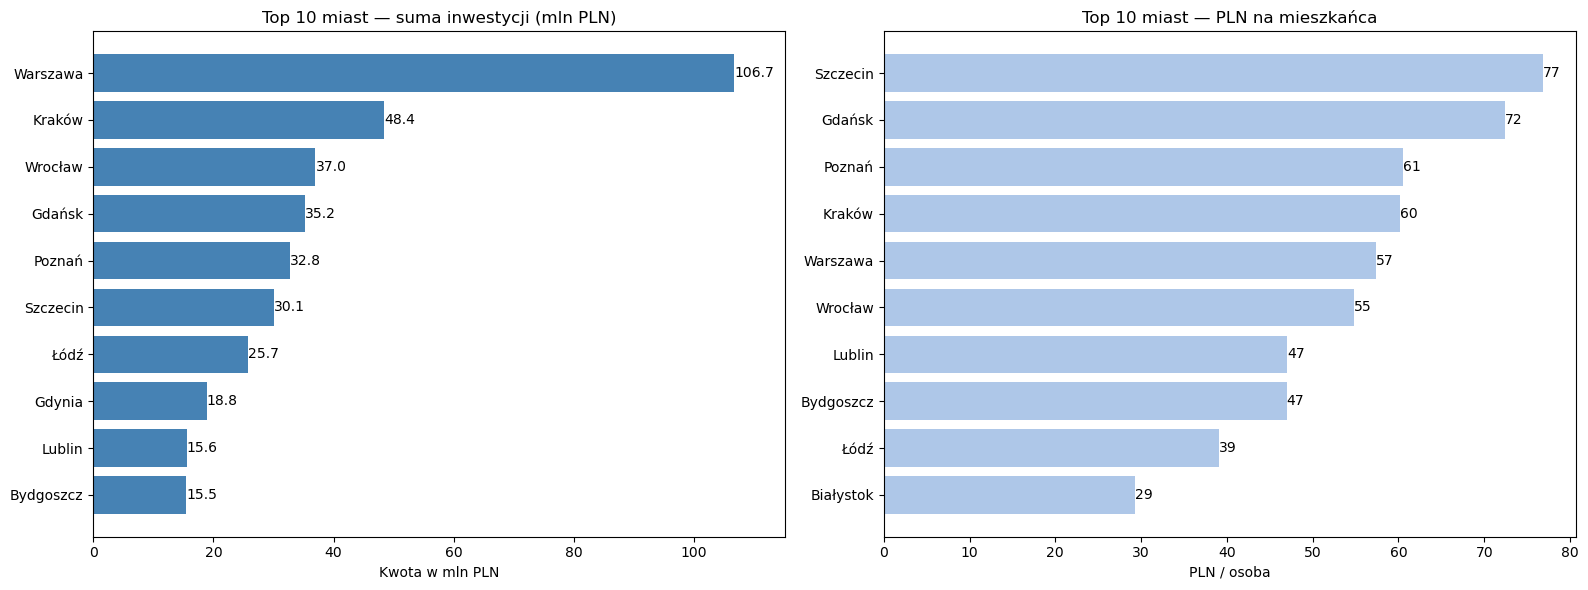

In [110]:
money_city = df.groupby('City')['Money'].sum().sort_values(ascending=False)
top10_money_city = money_city[:10]

city_pop = {
    "Warszawa": 1861975,
    "Kraków": 803283,
    "Łódź": 658444,
    "Wrocław": 675079,
    "Poznań": 541316,
    "Gdańsk": 486345,
    "Szczecin": 391566,
    "Bydgoszcz": 330038,
    "Lublin": 331243,
    "Białystok": 292600
}

city_per_capita = (money_city / pd.Series(city_pop)).dropna()
top10_per_capita = city_per_capita.sort_values(ascending=False)[:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

bars1 = ax1.barh(top10_money_city.index[::-1], (top10_money_city.values/1e6)[::-1], color='steelblue')
ax1.set_title("Top 10 miast — suma inwestycji (mln PLN)")
ax1.set_xlabel("Kwota w mln PLN")
ax1.bar_label(bars1, fmt='%.1f', label_type='edge')
ax1.set_xlim(0, max(top10_per_capita.values) * 1.5)

bars2 = ax2.barh(top10_per_capita.index[::-1], top10_per_capita.values[::-1], color='#aec7e8')
ax2.set_title("Top 10 miast — PLN na mieszkańca")
ax2.set_xlabel("PLN / osoba")
ax2.bar_label(bars2, fmt='%.0f', label_type='edge')

plt.tight_layout()
plt.savefig("city.png", dpi=300, bbox_inches='tight')

plt.show()


### Funding statistics

C:\Users\WIZBOX\AppData\Local\Temp\ipykernel_9324\3987961336.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


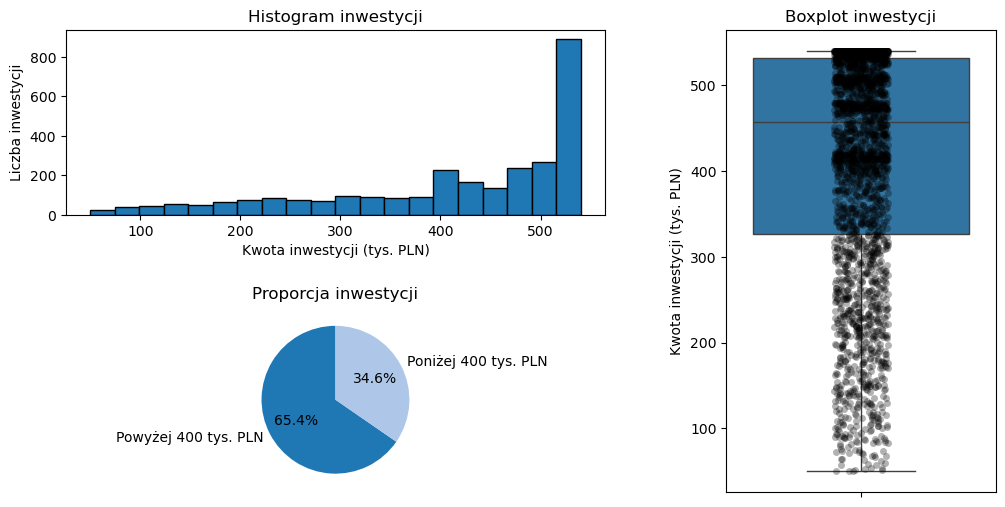

In [112]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 2, width_ratios=[2,1], height_ratios=[1,1], hspace=0.5, wspace=0.3)

# Kolory
main_color = '#1f77b4'
light_color = '#aec7e8'

money_thousands = df['Money'] / 1000

# Histogram (lewy górny)
ax_hist = fig.add_subplot(gs[0,0])
ax_hist.hist(money_thousands, bins=20, color=main_color, edgecolor='black')
ax_hist.set_title("Histogram inwestycji")
ax_hist.set_xlabel("Kwota inwestycji (tys. PLN)")
ax_hist.set_ylabel("Liczba inwestycji")

# Wykres kołowy (lewy dolny)
ax_pie = fig.add_subplot(gs[1,0])
more400 = df['Money'] >= 400000
less400 = df['Money'] < 400000
ax_pie.pie([more400.sum(), less400.sum()],
           labels=['Powyżej 400 tys. PLN', 'Poniżej 400 tys. PLN'],
           autopct='%1.1f%%',
           colors=[main_color, light_color],
           startangle=90)
ax_pie.set_title("Proporcja inwestycji")

# Boxplot (prawa kolumna)
ax_box = fig.add_subplot(gs[:,1])
sns.boxplot(y=money_thousands, ax=ax_box, color=main_color)
sns.stripplot(y=money_thousands, ax=ax_box,
              jitter=True,
              marker='o',
              alpha=0.3,
              color='black')
ax_box.set_title("Boxplot inwestycji")
ax_box.set_ylabel("Kwota inwestycji (tys. PLN)")

plt.tight_layout()

plt.savefig("proportions.png", dpi=300, bbox_inches='tight')

plt.show()


### Wordclouds

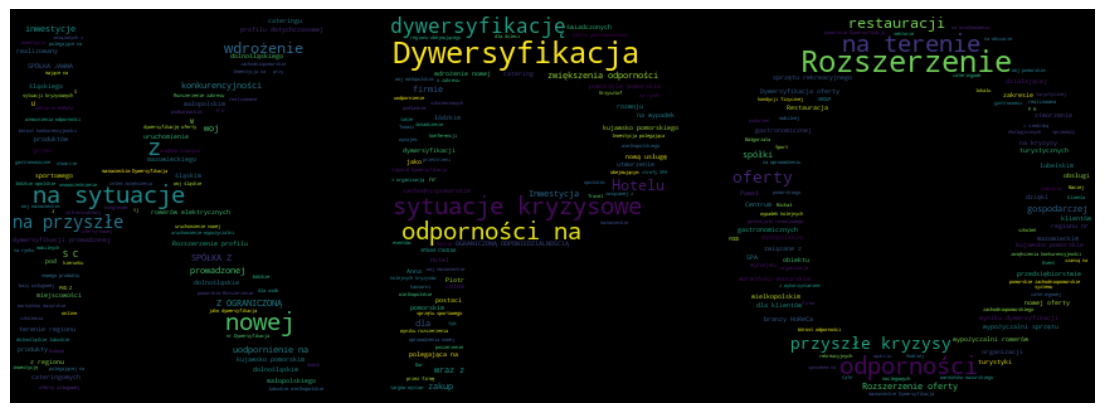

In [114]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# MASKA KPO
W, H = 1200, 600
img = Image.new("L", (W, H), 0)  # czarne tło
draw = ImageDraw.Draw(img)

try:
    font = ImageFont.truetype("arialbd.ttf", 420)  # Arial gruby
except:
    font = ImageFont.load_default()

text = "KPO"
bbox = draw.textbbox((0, 0), text, font=font)
x = (W - (bbox[2] - bbox[0])) // 2
y = (H - (bbox[3] - bbox[1])) // 2
draw.text((x, y), text, fill=255, font=font)  # białe litery na czarnym tle

mask_gray = np.array(img)

# BINARYZACJA
mask_bin = np.where(mask_gray > 0, 255, 0).astype(np.uint8)
mask_bin = 255 - mask_bin # odwrócenie maski

# Bounding box białych pikseli
ys, xs = np.where(mask_bin == 0)
min_x, max_x = xs.min(), xs.max()
min_y, max_y = ys.min(), ys.max()

# Przycięcie maski
mask_bin = mask_bin[min_y:max_y+1, min_x:max_x+1]

# Tekst z kolumny Investment
text_data = " ".join(df["Investment"].dropna().astype(str).tolist())
text_data = re.sub(r"[^a-zA-ZąćęłńóśźżĄĆĘŁŃÓŚŹŻ\s]", " ", text_data)

# Stopwords
polish_stops = {
    "projekt","realizacja","rozwój","modernizacja","wzmocnienie","działalności","działalność",
    "przedsiębiorstwa","przedsiębiorstwo","poprzez","nowych","nowe","usług","usługi","celu",
    "region","województwie","województwa","województwo","ramach","wprowadzenie","zwiększenie",
    "oraz", "Sp", "firmy", "W", "o", "regionie"
}

stops = STOPWORDS.union(polish_stops)

wc = WordCloud(
    mask=mask_bin,
    background_color="black",
    colormap='viridis',
    max_words=800,
    stopwords=stops,
    prefer_horizontal=1.0,
    repeat=True,
    random_state=42
).generate(text_data)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("kpo.png", dpi=300, bbox_inches='tight')

plt.show()

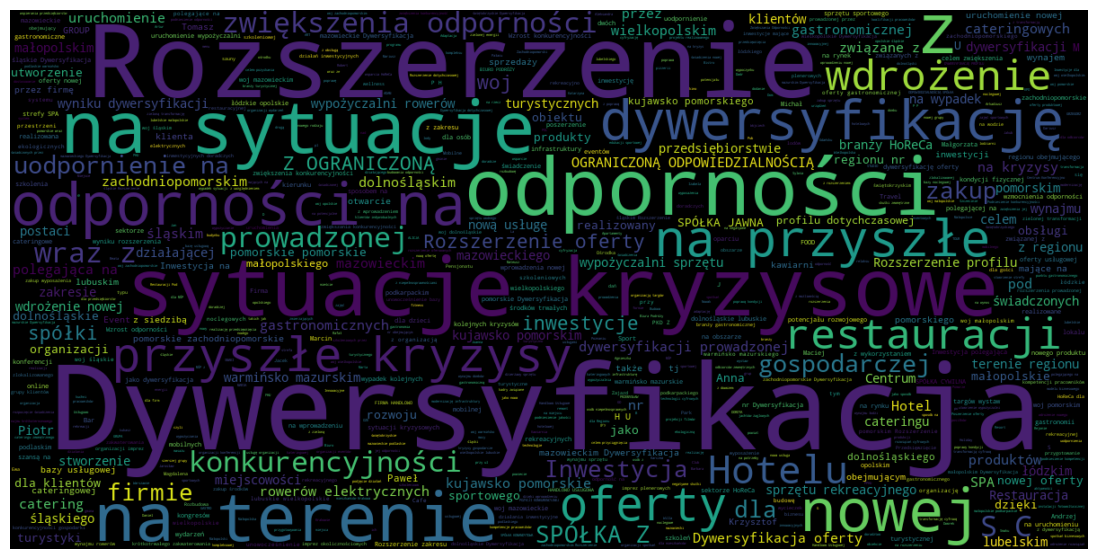

In [115]:
wc_plain = WordCloud(
    background_color="black",
    colormap='viridis',
    max_words=800,
    stopwords=stops,
    width=1200,
    height=600,
    prefer_horizontal=1.0,
    random_state=42
).generate(text_data)

plt.figure(figsize=(14,7))
plt.imshow(wc_plain, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.png", dpi=300, bbox_inches='tight')
plt.show()


### Funding per category

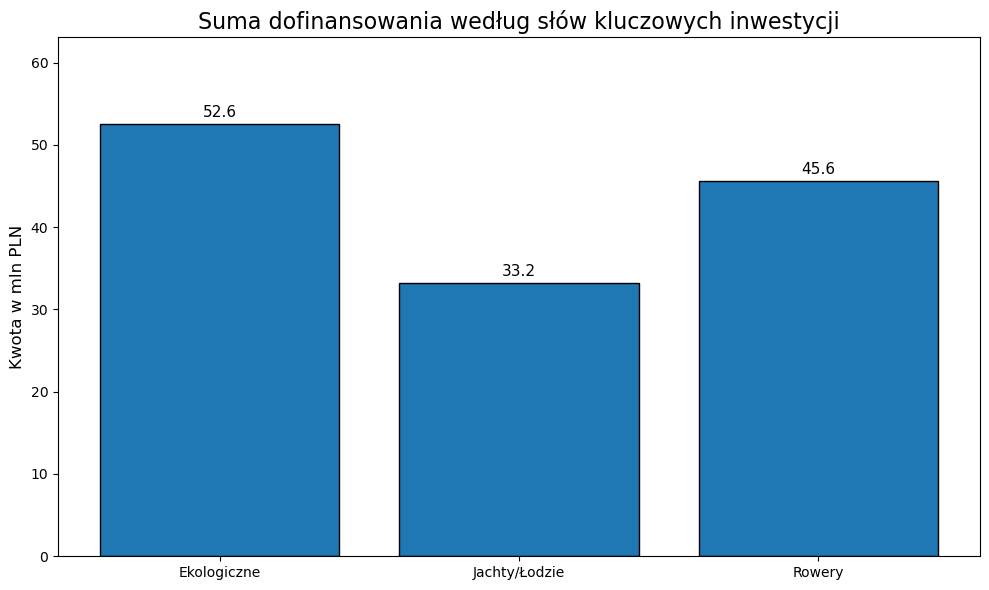

In [117]:
categories = {
    "Ekologiczne": ["ekologi", "zeroemisyjn", "odnawialn", "fotowolt", "panel", "solarn"],
    "Jachty/Łodzie": ["jacht", "łodzi"],
    "Rowery": ["rower"],
}

category_sums = {cat: 0 for cat in categories}
for _, row in df.iterrows():
    text = str(row["Investment"])
    amount = row["Money"]
    for cat, keywords in categories.items():
        if any(k in text for k in keywords):
            category_sums[cat] += amount

category_sums_mln = {k: v/1e6 for k,v in category_sums.items()}

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(category_sums_mln.keys(), category_sums_mln.values(),
              color='#1f77b4', edgecolor='black')

ax.bar_label(bars, fmt='%.1f', padding=3, fontsize=11)

ax.set_title("Suma dofinansowania według słów kluczowych inwestycji", fontsize=16)
ax.set_ylabel("Kwota w mln PLN", fontsize=12)
max_height = max(category_sums_mln.values())
ax.set_ylim(0, max_height * 1.2)  # 20% więcej miejsca nad najwyższym słupkiem

plt.tight_layout()
plt.savefig("cat.png", dpi=300, bbox_inches='tight')

plt.show()

## Final words

Dzięki za dotarcie do końca!  
Możesz znaleźć mnie tutaj:  
Linkedin: www.linkedin.com/in/jakub-flak  
Github: https://github.com/JakubFlak